In [6]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from itertools import *
# Just essential tools

In [2]:
df = pd.read_pickle('data/KAS_USDT_5m_300_days_data.pkl')
df_1 = pd.read_pickle('data/KAS_USDT_1m_10_days_data.pkl')

df.head(3)
# df is a 5-minute dataframe, where each row is a 5-minute candle
# Same applies to df_1, but it's recent data and shorter

,open,close,high,low,volume
timestamp,,,,,
2024-01-05 11:55:00,0.112729,0.113025,0.113134,0.112401,67258.53
2024-01-05 12:00:00,0.113025,0.113068,0.113529,0.11283,132406.52
2024-01-05 12:05:00,0.113068,0.1119,0.113068,0.111899,196303.66


In [3]:
print(len(df))
df.info()
# As we can see, df is very good as it doesn't contain any null values, this is because
# df is got throug API of exchange MEXC, and it would be worst nightmare for an exchange to 
# have any undefined values in their data.

# Also keep in mind that crypto exhanges work 24/7 without holidays or breaks, so data
# doesn't have any gaps

# Unfortunately when data is fetched, all values are converted into objects, whily they clearly are
# intended to be floats 

17300
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17300 entries, 2024-01-05 11:55:00 to 2024-10-30 10:50:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   open    17300 non-null  object
 1   close   17300 non-null  object
 2   high    17300 non-null  object
 3   low     17300 non-null  object
 4   volume  17300 non-null  object
dtypes: object(5)
memory usage: 810.9+ KB


In [4]:
df = df.astype({'high': float, 'low': float, 'open': float, "close": float, 'volume': float})
df.describe()

# Now after type conversion (which could be done at the moment of import) we can get basic 
# understanding of our dataframe. 

,open,close,high,low,volume
count,17300.000000,17300.000000,17300.000000,17300.000000,1.730000e+04
mean,0.145492,0.145493,0.145756,0.145181,2.233928e+05
std,0.024698,0.024696,0.024725,0.024665,3.470606e+05
min,0.095761,0.095761,0.096825,0.095600,0.000000e+00
25%,0.125451,0.125451,0.125698,0.125103,5.144840e+04
50%,0.146234,0.146241,0.146537,0.146000,1.168319e+05
75%,0.166471,0.166478,0.166714,0.166200,2.511642e+05
max,0.207599,0.207599,0.207914,0.207046,6.126775e+06


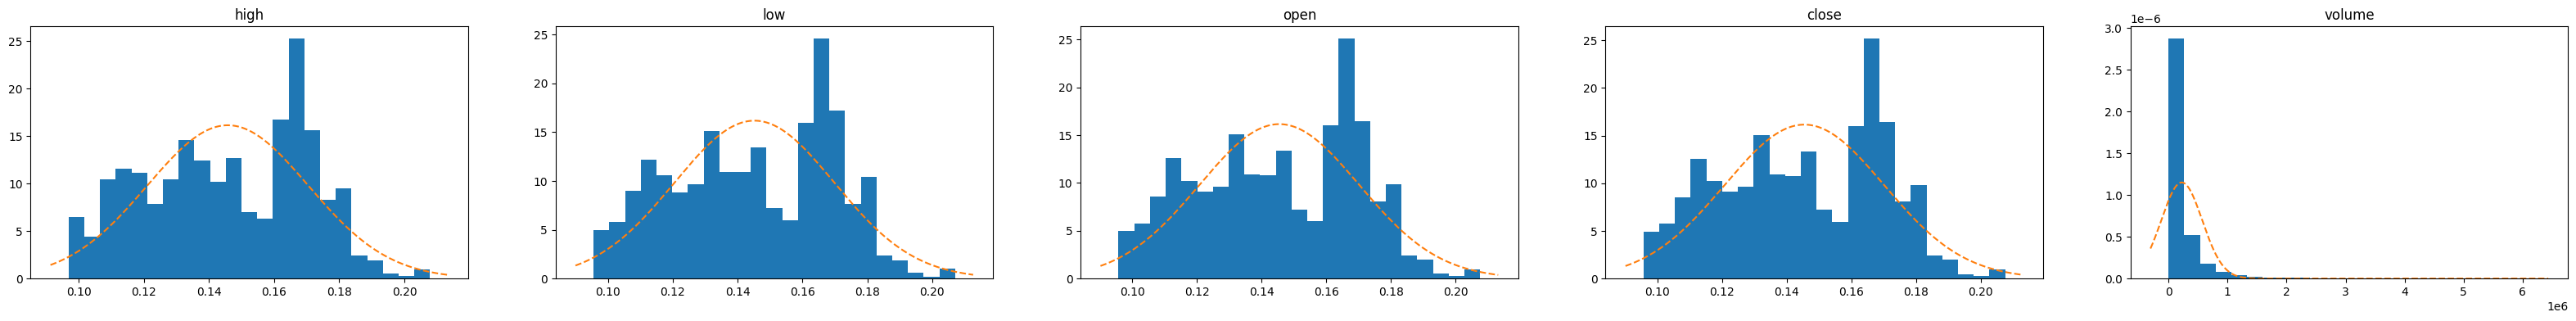

In [ ]:
keys = ['high', 'low', 'open', 'close', 'volume']
fig, axes = plt.subplots(ncols=len(keys))
fig.set_size_inches(8 * len(keys), 4)
axes = axes.flatten()

for key, ax in zip(keys, axes):
    ax.hist(df[key], density=True, bins=23)
    
    loc = df[key].mean()
    scale = df[key].std()
    
    x_left, x_right = ax.get_xlim()
    x = np.linspace(x_left, x_right, 10000)
    y = stats.norm.pdf(x, loc=loc, scale=scale)
    
    ax.plot(x, y, linestyle='dashed')
    ax.set_title(key)

# As we can clearly see there's no normal distribution, and that is to be expected. It would be strange

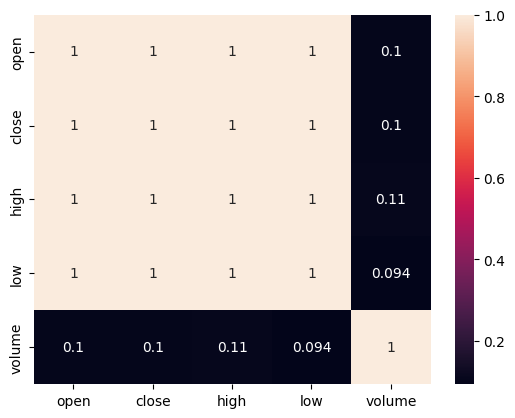

In [ ]:
sns.heatmap(df.corr(), annot=True)
plt.show()

# As we can see here automatic methods for correletion show us very strange picture: as if 
# opening price is always dependent linearly on closing price. As we know from firsthand excperience
# and common logic, it's just plainly false. The reason for such strange output is radical
# diffetence between prices and volume. While price is measured in fractions of dollars, volume is
# measured by millions of dollars. There are two major approaches in this situation: either we
# drop volum col entirely or normalize it. Let's do first approach as it is simpler to implement

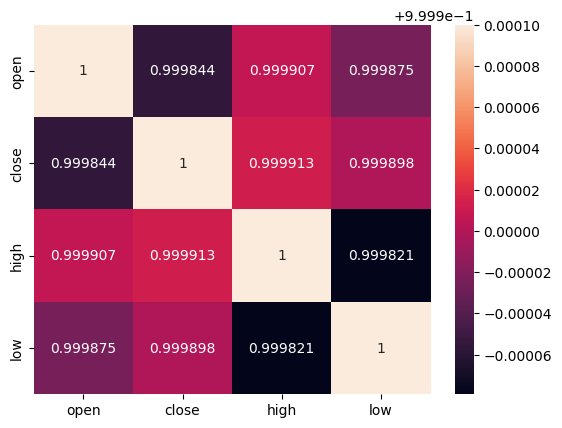

In [ ]:
df_no_volume = df.drop(columns='volume')
sns.heatmap(df_no_volume.corr(), annot=True, fmt='g')
plt.show()

# Now we can see that prices, highs and lows still have strong correlation, as I see it, it means
# that price spikes during one candle are very rare and incegnifficant. Let's test it

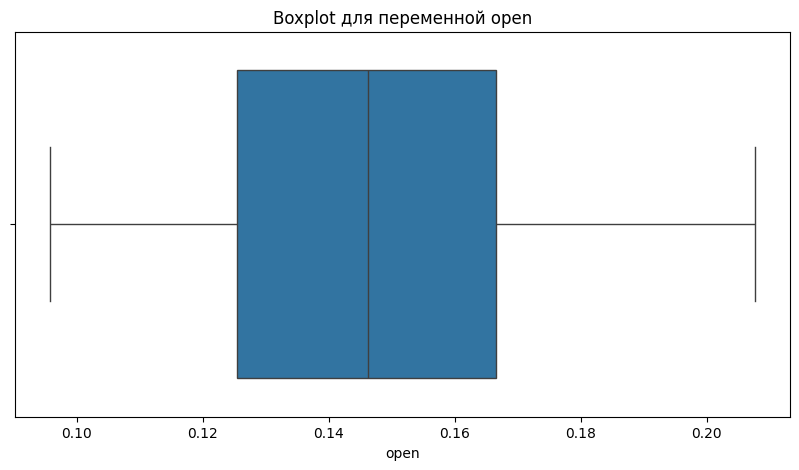

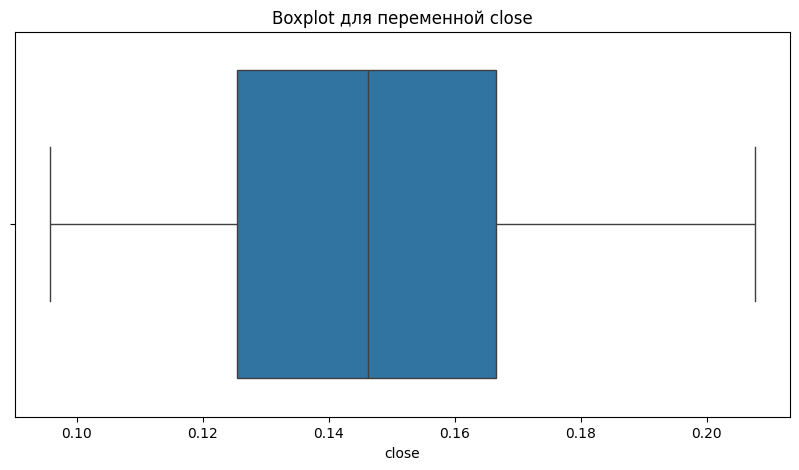

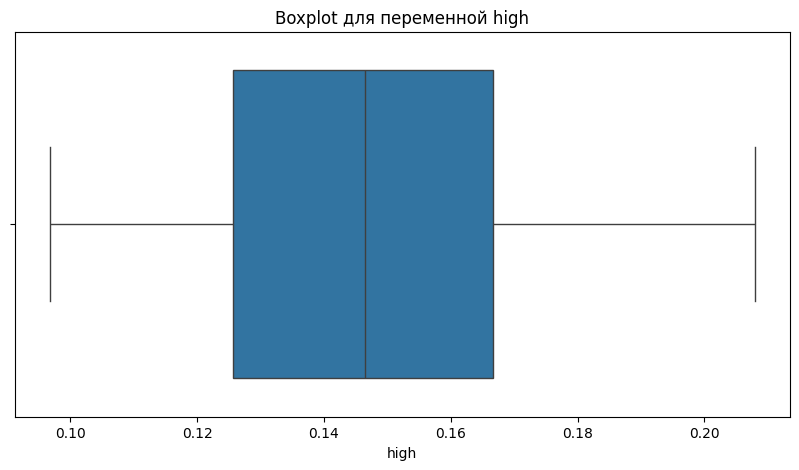

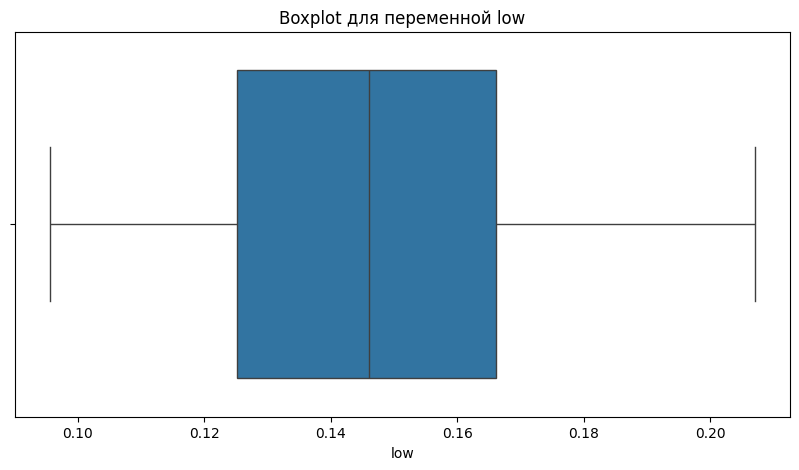

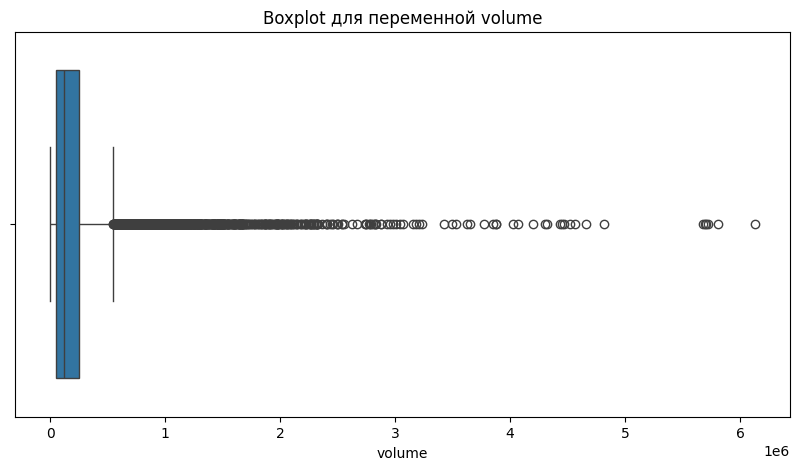


Выбросы в колонке volume:
                         open     close      high       low      volume
timestamp                                                              
2024-01-05 12:15:00  0.111999  0.112828  0.114139  0.111802   620288.95
2024-01-05 13:10:00  0.111843  0.111917  0.113200  0.111584   555328.28
2024-01-05 13:50:00  0.112299  0.111800  0.112833  0.111505   553572.67
2024-01-05 14:20:00  0.110747  0.110302  0.110747  0.110000  1001416.78
2024-01-05 14:25:00  0.110302  0.110000  0.110333  0.110000   636141.81
...                       ...       ...       ...       ...         ...
2024-10-30 09:10:00  0.110393  0.110283  0.110496  0.109980   696692.01
2024-10-30 09:45:00  0.108830  0.108367  0.109203  0.108000  1569914.22
2024-10-30 09:50:00  0.108367  0.108534  0.108686  0.108042   697309.56
2024-10-30 10:40:00  0.107654  0.107630  0.107897  0.107477   621928.38
2024-10-30 10:45:00  0.107630  0.107805  0.108000  0.107000  1208045.75

[1584 rows x 5 columns]


In [ ]:
for column in df.columns:
      plt.figure(figsize=(10, 5))
      sns.boxplot(x=df[column])
      plt.title(f'Boxplot для переменной {column}')
      plt.show()
      Q1 = df[column].quantile(0.25)
      Q3 = df[column].quantile(0.75)
      IQR = Q3 - Q1
      outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
      if not outliers.empty:
          print(f"\nВыбросы в колонке {column}:")
          print(outliers)
# Unusual results again: every column except volume fits into standart boxplot.
# Volume on the other hand is easy explainable: as coin grew in popularity (in line with 
# healing economy) people returned into crypto as it is riscier asset to have
# 
# Let's make our boxplots more exclusive 

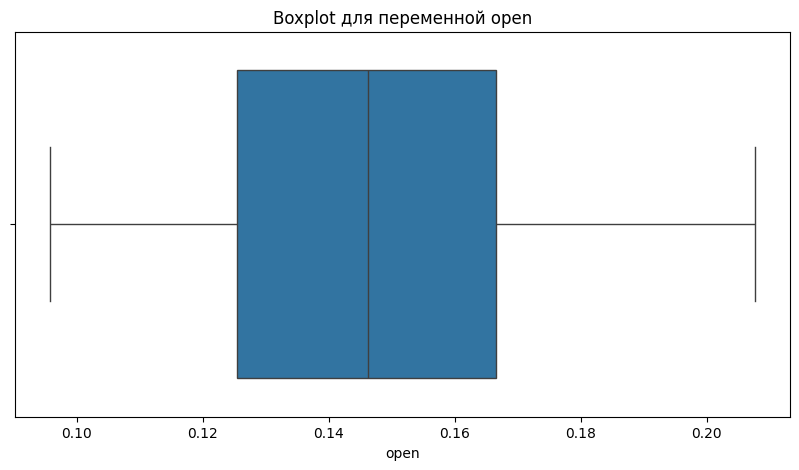


Выбросы в колонке open:
                         open     close      high       low     volume
timestamp                                                             
2024-01-05 17:05:00  0.107075  0.106009  0.107423  0.105749  915395.38
2024-01-05 17:10:00  0.106009  0.106100  0.106428  0.105755  995717.19
2024-01-05 17:15:00  0.106100  0.106414  0.106979  0.106088  535395.63
2024-01-05 17:20:00  0.106414  0.107055  0.108022  0.106414  373279.47
2024-01-05 17:25:00  0.107055  0.106852  0.107233  0.106667  120854.23
...                       ...       ...       ...       ...        ...
2024-08-02 17:30:00  0.190321  0.190403  0.190661  0.190163   95730.98
2024-08-02 17:35:00  0.190403  0.190067  0.190403  0.189106  149773.53
2024-08-02 17:40:00  0.190067  0.189347  0.190427  0.189268  195393.29
2024-08-02 17:45:00  0.189347  0.189711  0.190174  0.189294  197182.71
2024-08-02 17:50:00  0.189711  0.188296  0.189989  0.188027  310664.25

[1225 rows x 5 columns]


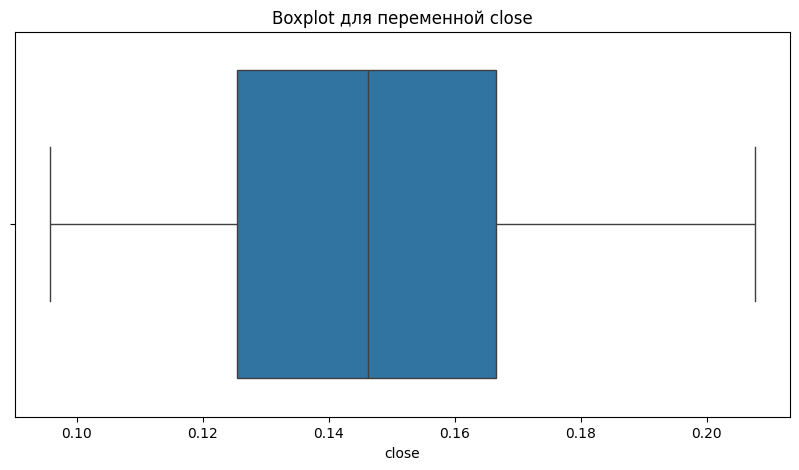


Выбросы в колонке close:
                         open     close      high       low     volume
timestamp                                                             
2024-01-05 17:05:00  0.107075  0.106009  0.107423  0.105749  915395.38
2024-01-05 17:10:00  0.106009  0.106100  0.106428  0.105755  995717.19
2024-01-05 17:15:00  0.106100  0.106414  0.106979  0.106088  535395.63
2024-01-05 17:25:00  0.107055  0.106852  0.107233  0.106667  120854.23
2024-01-19 09:15:00  0.101936  0.101589  0.102144  0.101573  131523.71
...                       ...       ...       ...       ...        ...
2024-08-02 17:20:00  0.190792  0.190327  0.190809  0.190316   65554.93
2024-08-02 17:25:00  0.190327  0.190321  0.190765  0.190169  133739.31
2024-08-02 17:30:00  0.190321  0.190403  0.190661  0.190163   95730.98
2024-08-02 17:35:00  0.190403  0.190067  0.190403  0.189106  149773.53
2024-08-02 17:45:00  0.189347  0.189711  0.190174  0.189294  197182.71

[1207 rows x 5 columns]


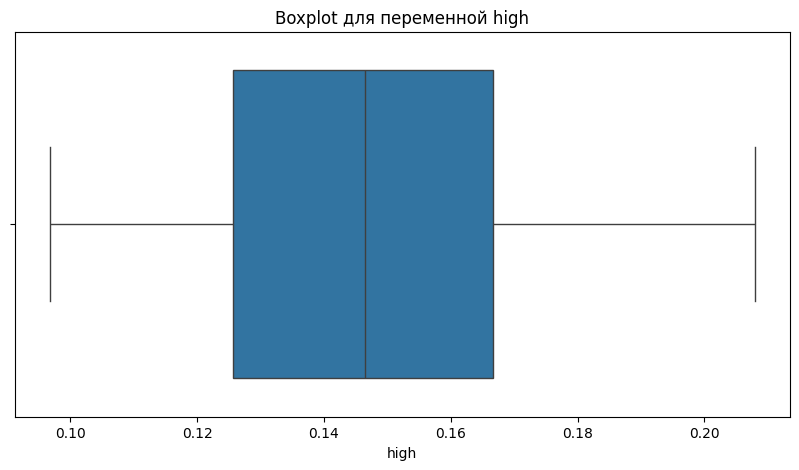


Выбросы в колонке high:
                         open     close      high       low     volume
timestamp                                                             
2024-01-05 17:10:00  0.106009  0.106100  0.106428  0.105755  995717.19
2024-01-05 17:15:00  0.106100  0.106414  0.106979  0.106088  535395.63
2024-01-19 09:15:00  0.101936  0.101589  0.102144  0.101573  131523.71
2024-01-19 09:20:00  0.101589  0.101441  0.101725  0.101368   19348.12
2024-01-19 09:25:00  0.101441  0.101298  0.101572  0.101101   38429.27
...                       ...       ...       ...       ...        ...
2024-08-02 17:30:00  0.190321  0.190403  0.190661  0.190163   95730.98
2024-08-02 17:35:00  0.190403  0.190067  0.190403  0.189106  149773.53
2024-08-02 17:40:00  0.190067  0.189347  0.190427  0.189268  195393.29
2024-08-02 17:45:00  0.189347  0.189711  0.190174  0.189294  197182.71
2024-08-02 17:50:00  0.189711  0.188296  0.189989  0.188027  310664.25

[1217 rows x 5 columns]


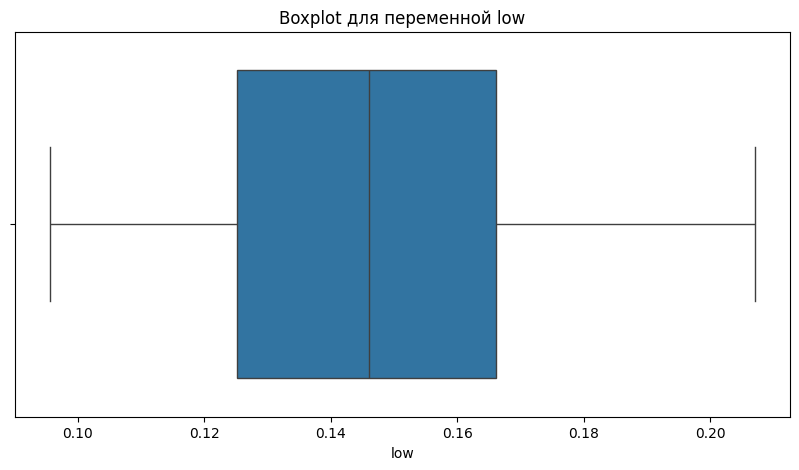


Выбросы в колонке low:
                         open     close      high       low      volume
timestamp                                                              
2024-01-05 17:00:00  0.107126  0.107075  0.107865  0.107075   435955.83
2024-01-05 17:05:00  0.107075  0.106009  0.107423  0.105749   915395.38
2024-01-05 17:10:00  0.106009  0.106100  0.106428  0.105755   995717.19
2024-01-05 17:15:00  0.106100  0.106414  0.106979  0.106088   535395.63
2024-01-05 17:20:00  0.106414  0.107055  0.108022  0.106414   373279.47
...                       ...       ...       ...       ...         ...
2024-08-02 17:30:00  0.190321  0.190403  0.190661  0.190163    95730.98
2024-08-02 17:35:00  0.190403  0.190067  0.190403  0.189106   149773.53
2024-08-02 17:40:00  0.190067  0.189347  0.190427  0.189268   195393.29
2024-08-02 17:45:00  0.189347  0.189711  0.190174  0.189294   197182.71
2024-10-30 10:45:00  0.107630  0.107805  0.108000  0.107000  1208045.75

[1265 rows x 5 columns]


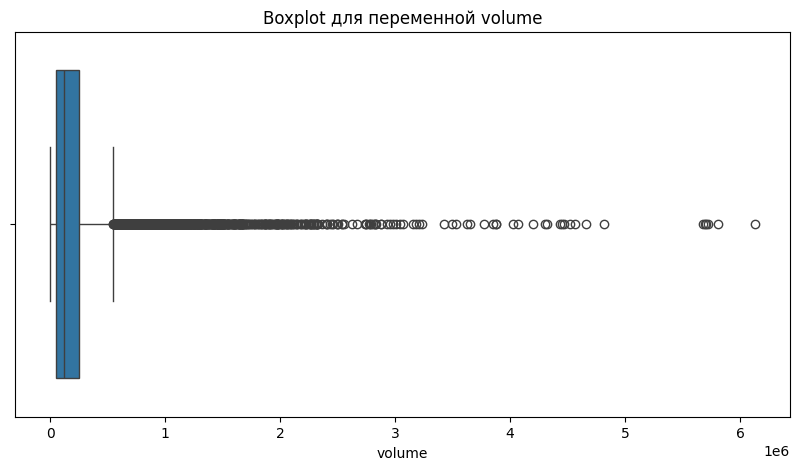


Выбросы в колонке volume:
                         open     close      high       low      volume
timestamp                                                              
2024-01-05 12:10:00  0.111900  0.111999  0.112253  0.111801   295115.27
2024-01-05 12:15:00  0.111999  0.112828  0.114139  0.111802   620288.95
2024-01-05 12:20:00  0.112828  0.112768  0.113140  0.112000   399689.20
2024-01-05 12:25:00  0.112768  0.112942  0.113450  0.112448   374448.69
2024-01-05 12:40:00  0.113150  0.112567  0.113150  0.112495   374957.66
...                       ...       ...       ...       ...         ...
2024-10-30 10:25:00  0.109000  0.108685  0.109010  0.108661   410586.04
2024-10-30 10:30:00  0.108685  0.108291  0.108816  0.108192   362580.03
2024-10-30 10:35:00  0.108291  0.107654  0.108291  0.107560   474184.71
2024-10-30 10:40:00  0.107654  0.107630  0.107897  0.107477   621928.38
2024-10-30 10:45:00  0.107630  0.107805  0.108000  0.107000  1208045.75

[4131 rows x 5 columns]


In [ ]:
for column in df.columns:
      plt.figure(figsize=(10, 5))
      sns.boxplot(x=df[column])
      plt.title(f'Boxplot для переменной {column}')
      plt.show()
      Q1 = df[column].quantile(0.4)
      Q3 = df[column].quantile(0.6)
      IQR = Q3 - Q1
      outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
      if not outliers.empty:
          print(f"\nВыбросы в колонке {column}:")
          print(outliers)

# IDEA: make column of % differences, and then make correlations